In [1]:
import pandas as pd
import numpy as np
import datetime as dtwaeg
import matplotlib.pyplot as plt
import seaborn as sns
import pyrsm as rsm
from lifetimes import BetaGeoFitter, GammaGammaFitter
from lifetimes.plotting import plot_frequency_recency_matrix, plot_probability_alive_matrix, plot_period_transactions
from lifetimes.utils import summary_data_from_transaction_data
import scipy.stats as stats
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import (
    GridSearchCV,
    ShuffleSplit,
    StratifiedShuffleSplit,
    train_test_split,
)
from sklearn.cluster import KMeans
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from statsmodels.genmod.families import Binomial
from statsmodels.genmod.families.links import logit

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

from math import sqrt

import matplotlib as mpl
import statsmodels.formula.api as smf
import xgboost as xgb
from sklearn import metrics, tree
import statsmodels.api as sm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from plotly.subplots import make_subplots

plt.rcParams["figure.dpi"] = 150


In [19]:
df = pd.read_csv("Retail_Data_Transactions.csv",parse_dates=['trans_date'])

print(df.head())

  customer_id trans_date  tran_amount
0      CS5295 2013-02-11           35
1      CS4768 2015-03-15           39
2      CS2122 2013-02-26           52
3      CS1217 2011-11-16           99
4      CS1850 2013-11-20           78


In [315]:
# df = pd.read_excel("online_retail_II.xlsx")

In [20]:
df['trans_date'] = pd.to_datetime(df['trans_date'], format="%Y-%m-%d").dt.date

In [21]:
import pandas as pd

def date_diff(date1_str, date2_str):
    # Convert date strings to pandas datetime objects
    date1 = pd.to_datetime(date1_str)
    date2 = pd.to_datetime(date2_str)

    # Calculate the timedelta between the two dates
    delta = date2 - date1

    # Return the delta in days as an integer
    return delta.days

In [22]:
min_date = df['trans_date'].min()
max_date = df['trans_date'].max()

# Calculate the total number of months in the dataset
total_months = (max_date.year - min_date.year) * 12 + (max_date.month - min_date.month)

In [23]:
def get_calibration_end_date_Month(percentage):
    # Calculate the desired percentage of the total months
    months_percentage = int(total_months * (percentage / 100))

    # Find the corresponding date for the calibration period end
    calibration_end_date = min_date + pd.DateOffset(months=months_percentage)
    
    print(f'Calibration duration: {months_percentage} months')
    print(f'Holdout duration: {int(total_months - months_percentage)} months')
    return calibration_end_date

In [171]:
get_calibration_end_date_Month(80)

Calibration duration: 36 months
Holdout duration: 10 months


Timestamp('2014-05-16 00:00:00')

In [281]:
from lifetimes.utils import calibration_and_holdout_data

rfm_cal_holdout = calibration_and_holdout_data(transactions=df,
                                               customer_id_col='customer_id', 
                                               datetime_col='trans_date',
                                               monetary_value_col = 'tran_amount',
                                               
                                               calibration_period_end=get_calibration_end_date_Month(90), # 70%
                                               observation_period_end=df.trans_date.max()) 

rfm_cal_holdout.head()

Calibration duration: 41 months
Holdout duration: 5 months


,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout
customer_id,,,,,,,
CS1112,12.0,1127.0,1219.0,71.500000,2.0,49.000000,151.0
CS1113,16.0,1159.0,1238.0,73.500000,2.0,73.333333,151.0
CS1114,15.0,1145.0,1190.0,76.266667,3.0,70.333333,151.0
CS1115,20.0,1043.0,1163.0,75.850000,1.0,55.000000,151.0
CS1116,12.0,1155.0,1207.0,64.166667,0.0,0.000000,151.0


In [287]:
# Duration of the holdout dataset
t = rfm_cal_holdout.duration_holdout[0]

# List of potential penalizer values
penalizer_values = np.linspace(0.0001, 0.0003, 10)

# Initialize a dictionary to store the results
results = {}

# Initialize the best RMSE to a very large number and best penalizer to None
best_RMSE = np.inf
best_penalizer = None

# Loop through the list of potential penalizer values
for penalizer in penalizer_values:
    # Instantiate the BG/NBD model
    bgf = BetaGeoFitter(penalizer_coef=penalizer)

    # Fit the model
    bgf.fit(frequency=rfm_cal_holdout['frequency_cal'], 
            recency=rfm_cal_holdout['recency_cal'], 
            T=rfm_cal_holdout['T_cal'])

    # Predict the number of transactions in the holdout period
    rfm_cal_holdout["frequency_holdout_pred"] = bgf.predict(t=t, 
                                                            frequency=rfm_cal_holdout['frequency_cal'], 
                                                            recency=rfm_cal_holdout['recency_cal'], 
                                                            T=rfm_cal_holdout['T_cal'])
    try:
        # Calculate the RMSE
        RMSE = mean_squared_error(y_true = rfm_cal_holdout["frequency_holdout"],
                                  y_pred = rfm_cal_holdout["frequency_holdout_pred"],
                                  squared = False)
        # Store the results
        results[penalizer] = RMSE

        # Check if this RMSE is the best
        if RMSE < best_RMSE:
            best_RMSE = RMSE
            best_penalizer = penalizer
    except ValueError:
        print(f'ValueError encountered for penalizer: {penalizer}. Skipping this value.')

# Print the results
for penalizer, RMSE in results.items():
    print(f'Penalizer: {penalizer}, RMSE: {RMSE}')

# Print the best penalizer
print(f'\nBest Penalizer: {best_penalizer}, Best RMSE: {best_RMSE}')


C:\Users\brigh\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\brigh\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


ValueError encountered for penalizer: 0.00018888888888888888. Skipping this value.
ValueError encountered for penalizer: 0.0002111111111111111. Skipping this value.


C:\Users\brigh\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


ValueError encountered for penalizer: 0.00023333333333333333. Skipping this value.
ValueError encountered for penalizer: 0.00025555555555555553. Skipping this value.


C:\Users\brigh\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


ValueError encountered for penalizer: 0.0002777777777777778. Skipping this value.
Penalizer: 0.0001, RMSE: 1.4484334791602238
Penalizer: 0.00012222222222222221, RMSE: 1.4491296554317978
Penalizer: 0.00014444444444444444, RMSE: 1.449753807071436
Penalizer: 0.00016666666666666666, RMSE: 1.450321393101605
Penalizer: 0.0003, RMSE: 1.4531187356931268

Best Penalizer: 0.0001, Best RMSE: 1.4484334791602238


C:\Users\brigh\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [288]:
# Refit BG/NBD model with the best penalizer
bgf = BetaGeoFitter(penalizer_coef=best_penalizer)

# Fit the model with the best penalizer
bgf.fit(frequency=rfm_cal_holdout['frequency_cal'], 
             recency=rfm_cal_holdout['recency_cal'], 
             T=rfm_cal_holdout['T_cal'])

<lifetimes.BetaGeoFitter: fitted with 6889 subjects, a: 0.00, alpha: 1319.64, b: 0.00, r: 17.02>

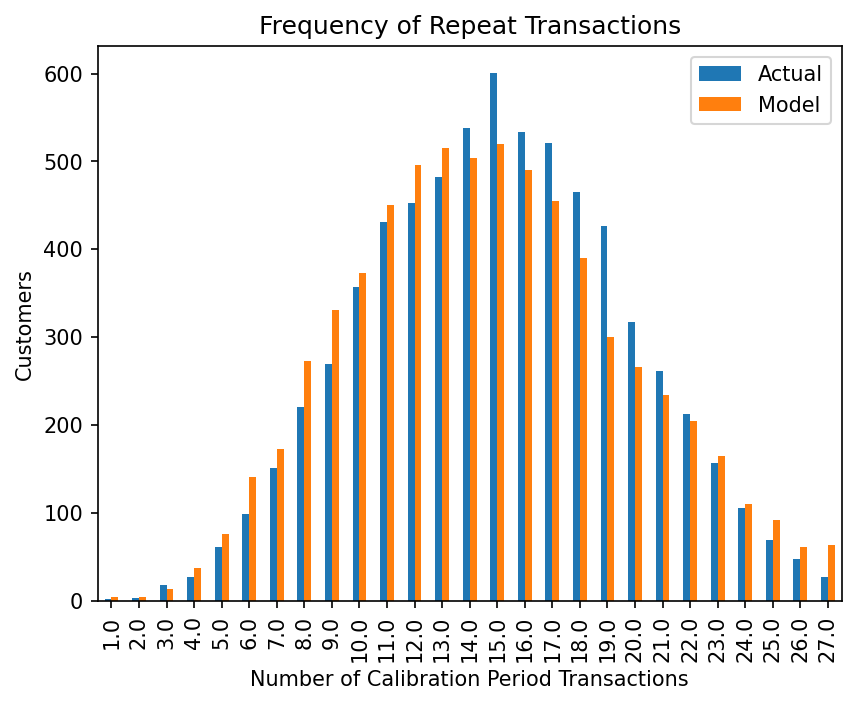

In [289]:
from lifetimes.plotting import plot_period_transactions

_ = plot_period_transactions(bgf, max_frequency=27) 

In [296]:
#### Fit the model using entire data

In [297]:
# Obtain summary data from Pendulum Customer Sales data
rfm = summary_data_from_transaction_data(transactions=df,
                                         customer_id_col='customer_id', 
                                         datetime_col='trans_date',
                                         monetary_value_col = 'tran_amount',
                                         observation_period_end=df.trans_date.max(),
                                         freq='D')

rfm.head()

,frequency,recency,T,monetary_value
customer_id,,,,
CS1112,14.0,1309.0,1370.0,68.285714
CS1113,18.0,1354.0,1389.0,77.555556
CS1114,18.0,1309.0,1341.0,75.277778
CS1115,21.0,1303.0,1314.0,74.857143
CS1116,12.0,1155.0,1358.0,64.166667


In [298]:
# similar API to scikit-learn and lifelines
bgf = BetaGeoFitter(penalizer_coef=best_penalizer)
bgf.fit(rfm['frequency'], rfm['recency'], rfm['T'])

<lifetimes.BetaGeoFitter: fitted with 6889 subjects, a: 0.00, alpha: 1368.97, b: 0.00, r: 17.63>

C:\Users\brigh\anaconda3\lib\site-packages\lifetimes\fitters\beta_geo_fitter.py:255: RuntimeWarning: invalid value encountered in double_scalars
  numerator = first_term * second_term
C:\Users\brigh\anaconda3\lib\site-packages\lifetimes\fitters\beta_geo_fitter.py:256: RuntimeWarning: divide by zero encountered in double_scalars
  denominator = 1 + (x > 0) * (a / (b + x - 1)) * ((alpha + T) / (alpha + recency)) ** (r + x)


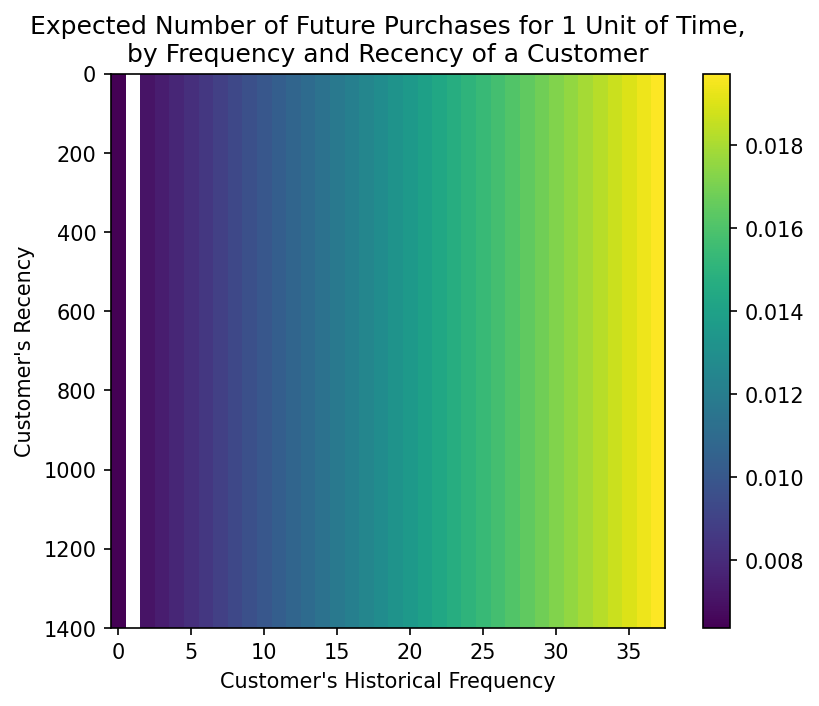

In [299]:
from lifetimes.plotting import plot_frequency_recency_matrix

_ = plot_frequency_recency_matrix(bgf)

<AxesSubplot:title={'center':'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

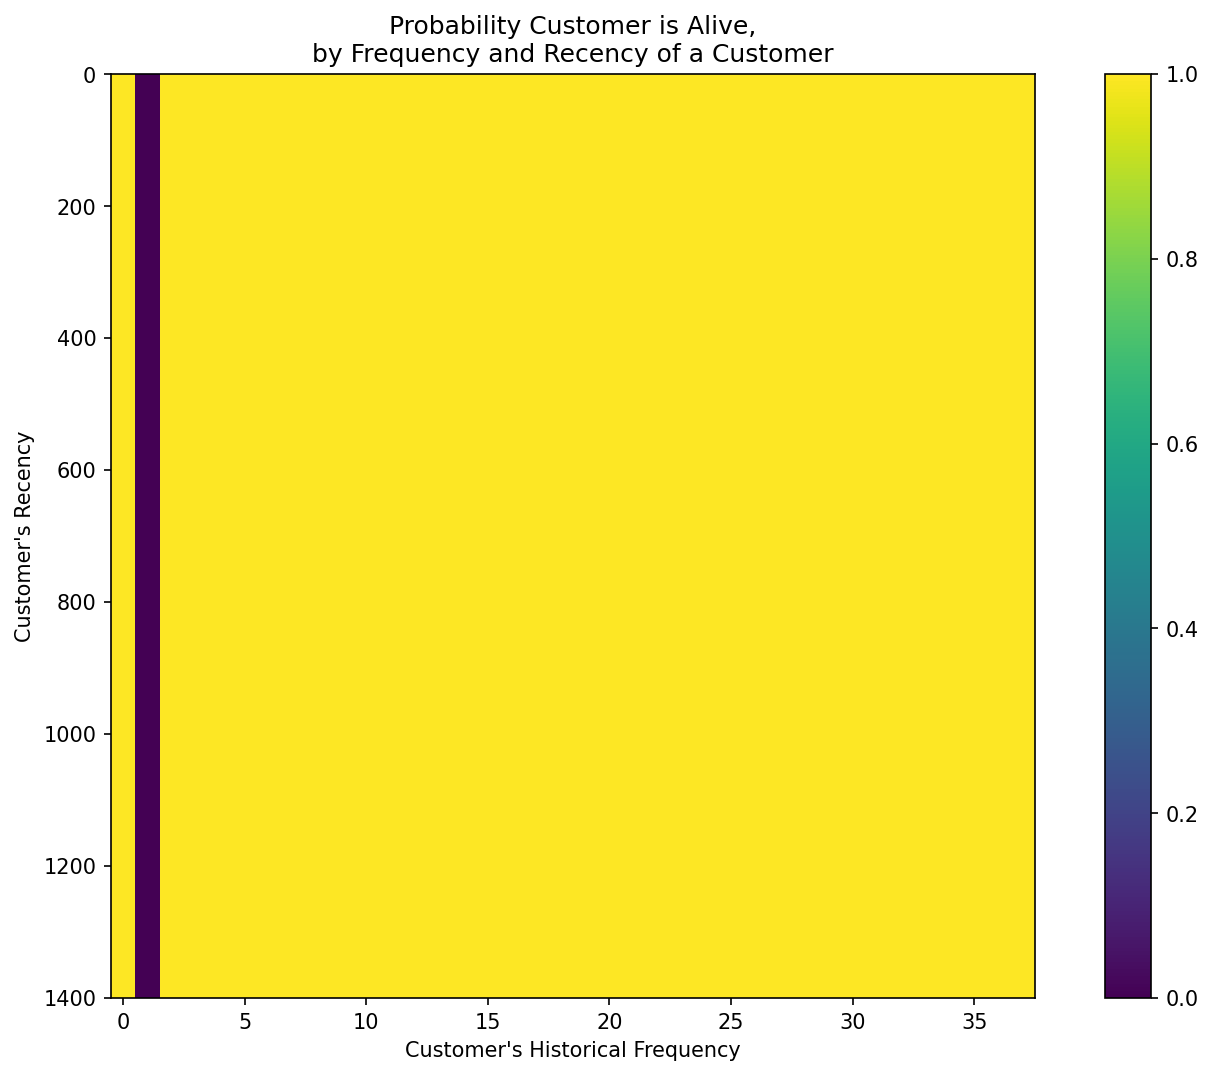

In [302]:
#Probability of customer still alive
from lifetimes.plotting import plot_probability_alive_matrix 
fig = plt.figure(figsize=(12,8)) 
plot_probability_alive_matrix(bgf) 

In [316]:
# The predicted number of purchases in the next 24 Months
t = 12 # Months
rfm[f"n_purch_{t}_pred"] = bgf.predict(t=t, 
                              frequency=rfm['frequency'],
                              recency=rfm['recency'],
                              T=rfm['T']
                              )

# Just as a reference - not using this in CLV calculation because it's already considered for purchase prediction
rfm["alive_prob"] = bgf.conditional_probability_alive(frequency=rfm['frequency'],
                                                                  recency=rfm['recency'],
                                                                  T=rfm['T']
                                                                  )

# multiplication predicted number of purchases x average past monetary value
rfm[f"CLV_{t}_NBD"] = rfm[f"n_purch_{t}_pred"]* \
                       rfm["monetary_value"]
                        # rfm["alive_prob"]
                        
rfm.shape

(6889, 9)

In [317]:
# Filter out non-positive values in the monetary_value column
pos_rfm = rfm[rfm['monetary_value'] > 0]

# Establishing the GAMMA-GAMMA Model
ggf = GammaGammaFitter(penalizer_coef=0.001).fit(pos_rfm['frequency'], 
                                                 pos_rfm['monetary_value'])

In [318]:
# Expected Average Future Profit
pos_rfm['exp_avg_profit'] = ggf.conditional_expected_average_profit(
                                                                   pos_rfm['frequency'], 
                                                                   pos_rfm['monetary_value']
                                                                   )

In [319]:
pos_rfm[f'CLV_{t}_gg_manual'] = (
                            pos_rfm[f'n_purch_{t}_pred'] * pos_rfm['exp_avg_profit']
)

In [320]:
clv = ggf.customer_lifetime_value(bgf,
                                   pos_rfm['frequency'],
                                   pos_rfm['recency'],
                                   pos_rfm['T'],
                                   pos_rfm['monetary_value'],
                                   time=t, # 6 MONTH
                                   freq="M", 
                                   discount_rate=0
)
pos_rfm = pos_rfm.merge(clv, on='customer_id').rename(columns={'clv':f'CLV_{t}_gg'})

In [321]:
pos_rfm.head(10)

,frequency,recency,T,monetary_value,n_purch_24_pred,alive_prob,CLV_24_NBD,n_purch_12_pred,CLV_12_NBD,exp_avg_profit,CLV_12_gg_manual,CLV_12_gg
customer_id,,,,,,,,,,,,
CS1112,14.0,1309.0,1370.0,68.285714,0.277141,1.0,18.924799,0.138571,9.462399,68.375829,9.474887,9.474887
CS1113,18.0,1354.0,1389.0,77.555556,0.310040,1.0,24.045356,0.155020,12.022678,77.533230,12.019217,12.019217
CS1114,18.0,1309.0,1341.0,75.277778,0.315532,1.0,23.752545,0.157766,11.876273,75.278209,11.876341,11.876341
CS1115,21.0,1303.0,1314.0,74.857143,0.345543,1.0,25.866383,0.172772,12.933192,74.861121,12.933879,12.933879
CS1116,12.0,1155.0,1358.0,64.166667,0.260759,1.0,16.732035,0.130379,8.366017,64.333000,8.387704,8.387704
CS1117,16.0,1139.0,1396.0,67.937500,0.291895,1.0,19.830645,0.145948,9.915322,68.020386,9.927419,9.927419
CS1118,14.0,1396.0,1398.0,69.142857,0.274337,1.0,18.968437,0.137168,9.484219,69.221993,9.495074,9.495074
CS1119,14.0,1101.0,1112.0,75.571429,0.305962,1.0,23.121972,0.152981,11.560986,75.568220,11.560495,11.560495
CS1120,23.0,1380.0,1390.0,70.608696,0.353423,1.0,24.954708,0.176711,12.477354,70.645621,12.483879,12.483879


In [322]:
desc = pos_rfm.describe().T[['mean','std','min','max']]

# Get the 'PENDULUM_ID' for the maximum and minimum of each criteria
max_ids = pos_rfm.idxmax()
min_ids = pos_rfm.idxmin()

# Append the max_ids and min_ids to the description DataFrame
desc['min_id'] = min_ids.values
desc['max_id'] = max_ids.values

desc


,mean,std,min,max,min_id,max_id
frequency,17.029903,5.131175,3.000000,37.000000,CS7224,CS4320
recency,1240.888663,122.859130,152.000000,1400.000000,CS8376,CS1791
T,1321.426912,84.652512,506.000000,1400.000000,CS8504,CS1177
monetary_value,63.478702,12.730800,24.666667,89.947368,CS7333,CS5677
n_purch_24_pred,0.309048,0.043909,0.185149,0.475380,CS8559,CS4320
alive_prob,1.000000,0.000000,1.000000,1.000000,CS1112,CS1112
CLV_24_NBD,19.907816,5.659210,4.813862,36.629063,CS8559,CS4424
n_purch_12_pred,0.154524,0.021954,0.092574,0.237690,CS8559,CS4320
CLV_12_NBD,9.953908,2.829605,2.406931,18.314532,CS8559,CS4424
exp_avg_profit,63.650293,12.518663,25.897790,89.808854,CS8595,CS5677


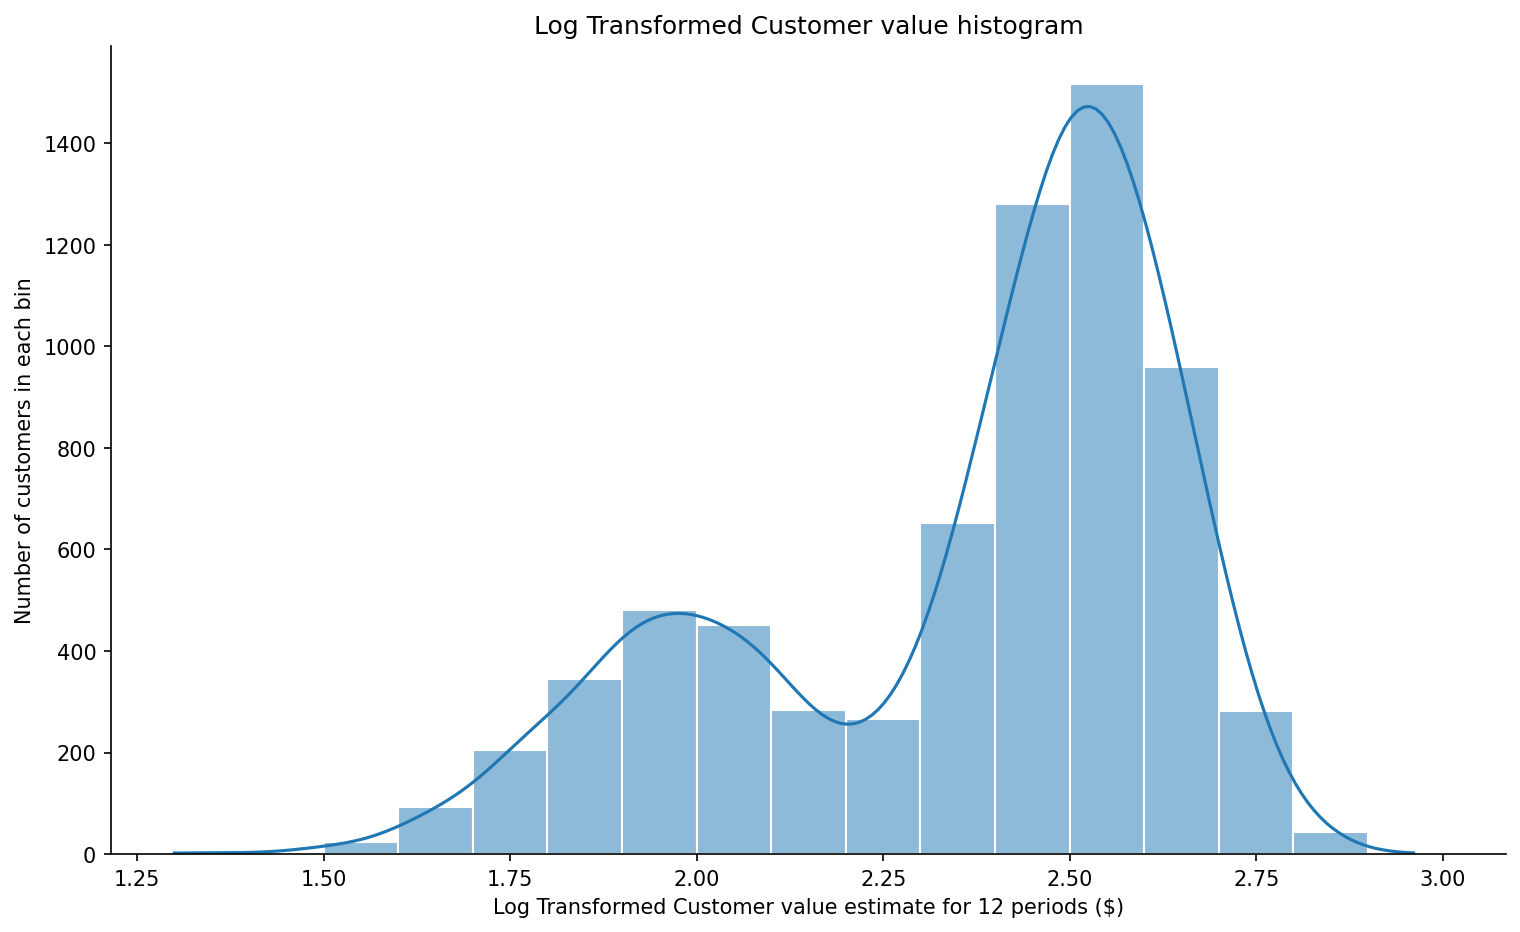

In [323]:
# Log transformation of the column 'CLV_{t}_gg'
pos_rfm['CLV_LOG'] = np.log1p(pos_rfm[f"CLV_{t}_gg"])

fig, ax = plt.subplots(figsize = (12, 7))
ax = sns.histplot(pos_rfm[f"CLV_LOG"], 
                  kde=True, 
                  binwidth = 0.1,edgecolor='white')  # binwidth adjusted due to the log scale
ax.set_title(f'Log Transformed Customer value histogram')
ax.set_xlabel(f'Log Transformed Customer value estimate for {t} periods ($)')
ax.set_ylabel(r'Number of customers in each bin')

# Remove top and right frame lines
sns.despine()

plt.show()
